In [2]:
from __future__ import print_function

In [3]:
import sys
'Python version: %s.%s' % (sys.version_info.major, sys.version_info.minor)

'Python version: 2.7'

In [4]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import graphviz
import html5lib

In [5]:
print('Requests: %s' % requests.__version__)
print('BeautifulSoup: %s'% bs4.__version__)
print('Pandas: %s'% pd.__version__)
print('Graphviz: %s' % graphviz.__version__)
%matplotlib inline

Requests: 2.13.0
BeautifulSoup: 4.5.3
Pandas: 0.19.2
Graphviz: 0.7.1


In [6]:
df_01 = pd.read_csv('data/sydney-uni-internal_html-90p-01.csv', index_col=None, header='infer')
df_02 = pd.read_csv('data/sydney-uni-internal_html-90p-02.csv', index_col=None, header='infer')
df_03 = pd.read_csv('data/sydney-uni-internal_html-90p-03.csv', index_col=None, header='infer')
df_04 = pd.read_csv('data/sydney-uni-internal_html-90p-04.csv', index_col=None, header='infer')
df_05 = pd.read_csv('data/sydney-uni-internal_html-90p-05.csv', index_col=None, header='infer')

/Users/amandaparker/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/amandaparker/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/amandaparker/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,10,16,18,20,26,28,30,32,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/amandaparker/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,18,20,30,31,32,41,42) have mixed types. Specify dtype option o

In [7]:
df = pd.concat([df_01, df_02, df_03, df_04, df_05])

In [8]:
urls = df['Address'].copy()

In [9]:
type(urls)

pandas.core.series.Series

In [10]:
with open('sitemap_urls.dat', 'w') as f:
    for url in urls:
        f.write(url + '\n')

In [11]:
sitemap_urls = open('sitemap_urls.dat', 'r').read().splitlines()
print('Loaded {:,} URLs'.format(len(sitemap_urls)))

Loaded 276,807 URLs


In [12]:
# sitemap_urls

In [13]:
def peel_layers(urls, layers=3):
    ''' Builds a dataframe containing all unique page identifiers up
    to a specified depth and counting the number of sub-pages for each.
    Prints results to a CSV file.

    urls : list
        List of page URLs.

    layers : int
        Depth of automated URL search. Large values for this parameter
        may cause long runtimes depending on the number of URLs.
    '''

    # Store results in a dataframe
    sitemap_layers = pd.DataFrame()

    # Get base levels
    bases = pd.Series([url.split('//')[-1].split('/')[0] for url in urls])
    sitemap_layers[0] = bases

    # Get specified number of layers
    for layer in range(1, layers+1):

        page_layer = []
        for url, base in zip(urls, bases):
            try:
                page_layer.append(url.split(base)[-1].split('/')[layer])
            except:
                # There is nothing that deep!
                page_layer.append('')

        sitemap_layers[layer] = page_layer

    # Count and drop duplicate rows + sort
    sitemap_layers = sitemap_layers.groupby(list(range(0, layers+1)))[0].count()\
                     .rename('counts').reset_index()\
                     .sort_values('counts', ascending=False)\
                     .sort_values(list(range(0, layers)), ascending=True)\
                     .reset_index(drop=True)
    
    # Convert column names to string types and export
    sitemap_layers.columns = [str(col) for col in sitemap_layers.columns]
    sitemap_layers.to_csv('sitemap_layers.csv', index=False)

    # Return the dataframe
    return sitemap_layers

In [14]:
sitemap_layers_read = peel_layers(urls=sitemap_urls, layers=3)

In [23]:
sitemap_layers_one['1'].unique()

array(['', 'FYE', 'ab', 'about', 'about-us', 'about-us.html', 'about_us',
       'accessibility.html', 'accessibility.shtml', 'acmm', 'agriculture',
       'alumni', 'alumni-giving', 'alumni-giving.html', 'alumni_donors',
       'alumni_supporters', 'angkor', 'architecture', 'arms', 'arts',
       'audit_risk', 'calendar', 'campus-cards', 'campus-life',
       'campus-life.html', 'camt', 'card_centre', 'career-advisers',
       'career-advisers.html', 'careers', 'ccanesa', 'ccs', 'cdip', 'cet',
       'chaplains', 'charles-perkins-centre', 'china_studies_centre',
       'china_studies_centrechina_studies_centre', 'civil', 'clinic',
       'clinical_psychology', 'codcd', 'compass', 'confucius_institute',
       'contact', 'contact-us.html', 'contact.shtml', 'convocation',
       'copyright', 'cstudent', 'curiosity-season', 'current',
       'current_students', 'data-science', 'disclaimer.html',
       'disclaimer.shtml', 'edsw', 'education-portfolio',
       'education_social_work', 'ee

In [38]:
# #for subdomains e.g. intranet.sydney.edu.au
sitemap_layers_one = sitemap_layers_read[sitemap_layers_read['0']=='sydney.edu.au'] 
sitemap_layers = sitemap_layers_one[sitemap_layers_one['1']=='data-science'] 
# sitemap_layers = sitemap_layers_read.copy() # for top layer

In [39]:
### MAKE SITEMAP
#sitemap_layers

In [40]:
def make_sitemap_graph(df, layers=3, limit=50, size='8,5'):
    ''' Make a sitemap graph up to a specified layer depth.
    
    sitemap_layers : DataFrame
        The dataframe created by the peel_layers function 
        containing sitemap information.
    
    layers : int
        Maximum depth to plot.
        
    limit : int
        The maximum number node edge connections. Good to set this
        low for visualizing deep into site maps.
    '''
    
    
    # Check to make sure we are not trying to plot too many layers
    if layers > len(df) - 1:
        layers = len(df)-1
        print('There are only %d layers available to plot, setting layers=%d'
              % (layers, layers))
    
    
    # Initialize graph
    f = graphviz.Digraph('sitemap', filename='sitemap_graph_%d_layer' % layers)
    f.body.extend(['rankdir=LR', 'size="%s"' % size])
    
    
    def add_branch(f, names, vals, limit, connect_to=''):
        ''' Adds a set of nodes and edges to nodes on the previous layer. '''
        
        # Get the currently existing node names
        node_names = [item.split('"')[1] for item in f.body if 'label' in item]
        
        # Only add a new branch it it will connect to a previously created node
        if connect_to:
            if connect_to in node_names:
                for name, val in list(zip(names, vals))[:limit]:
                    f.node(name='%s-%s' % (connect_to, name), label=name)
                    f.edge(connect_to, '%s-%s' % (connect_to, name), label='{:,}'.format(val))
        

    f.attr('node', shape='rectangle') # Plot nodes as rectangles
    
    # Add the first layer of nodes
    for name, counts in df.groupby(['0'])['counts'].sum().reset_index()\
                          .sort_values(['counts'], ascending=False).values:
        f.node(name=name, label='{} ({:,})'.format(name, counts))
    
    if layers == 0:
        return f
    
    f.attr('node', shape='oval') # Plot nodes as ovals
    f.graph_attr.update()
    
    # Loop over each layer adding nodes and edges to prior nodes
    for i in range(1, layers+1):
        cols = [str(i_) for i_ in range(i)]
        for k in df[cols].drop_duplicates().values:
            
            # Compute the mask to select correct data
            mask = True
            for j, ki in enumerate(k):
                mask &= df[str(j)] == ki
                
            # Select the data then count branch size, sort, and truncate
            data = df[mask].groupby([str(i)])['counts'].sum()\
                    .reset_index().sort_values(['counts'], ascending=False)
                
            # Add to the graph
            add_branch(f,
                       names=data[str(i)].values,
                       vals=data['counts'].values,
                       limit=limit,
                       connect_to='-'.join(['%s']*i) % tuple(k))
            
    return f


def apply_style(f, style, title=''):
    ''' Apply the style and add a title if desired. More styling options are
    documented here: http://www.graphviz.org/doc/info/attrs.html#d:style
    
    f : graphviz.dot.Digraph
        The graph object as created by graphviz.
    
    style : str
        Available styles: 'light', 'dark'
        
    title : str
        Optional title placed at the bottom of the graph.
    '''
    
    dark_style = {
        'graph': {
            'label': title,
            'bgcolor': '#3a3a3a',
            'fontname': 'Helvetica',
            'fontsize': '18',
            'fontcolor': 'white',
        },
        'nodes': {
            'style': 'filled',
            'color': 'white',
            'fillcolor': 'black',
            'fontname': 'Helvetica',
            'fontsize': '14',
            'fontcolor': 'white',
        },
        'edges': {
            'color': 'white',
            'arrowhead': 'open',
            'fontname': 'Helvetica',
            'fontsize': '12',
            'fontcolor': 'white',
        }
    }

    light_style = {
        'graph': {
            'label': title,
            'fontname': 'Helvetica',
            'fontsize': '18',
            'fontcolor': 'black',
        },
        'nodes': {
            'style': 'filled',
            'color': 'black',
            'fillcolor': '#dbdddd',
            'fontname': 'Helvetica',
            'fontsize': '14',
            'fontcolor': 'black',
        },
        'edges': {
            'color': 'black',
            'arrowhead': 'open',
            'fontname': 'Helvetica',
            'fontsize': '12',
            'fontcolor': 'black',
        }
    }
    
    if style == 'light':
        apply_style = light_style
            
    elif style == 'dark':
        apply_style = dark_style
        
    f.graph_attr = apply_style['graph']
    f.node_attr = apply_style['nodes']
    f.edge_attr = apply_style['edges']
    
    return f

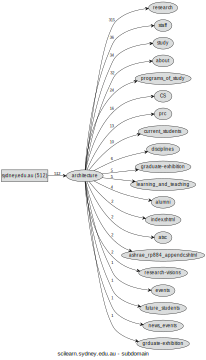

In [41]:
f = make_sitemap_graph(sitemap_layers, layers=2)
f = apply_style(f, 'light', title='scilearn.sydney.edu.au - subdomain')
f.render(cleanup=True)
f

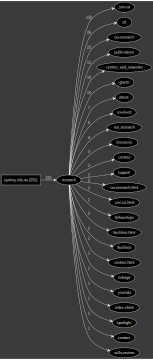

In [19]:
f = make_sitemap_graph(sitemap_layers, layers=2)
f = apply_style(f, 'dark')
f.render(cleanup=True)
f

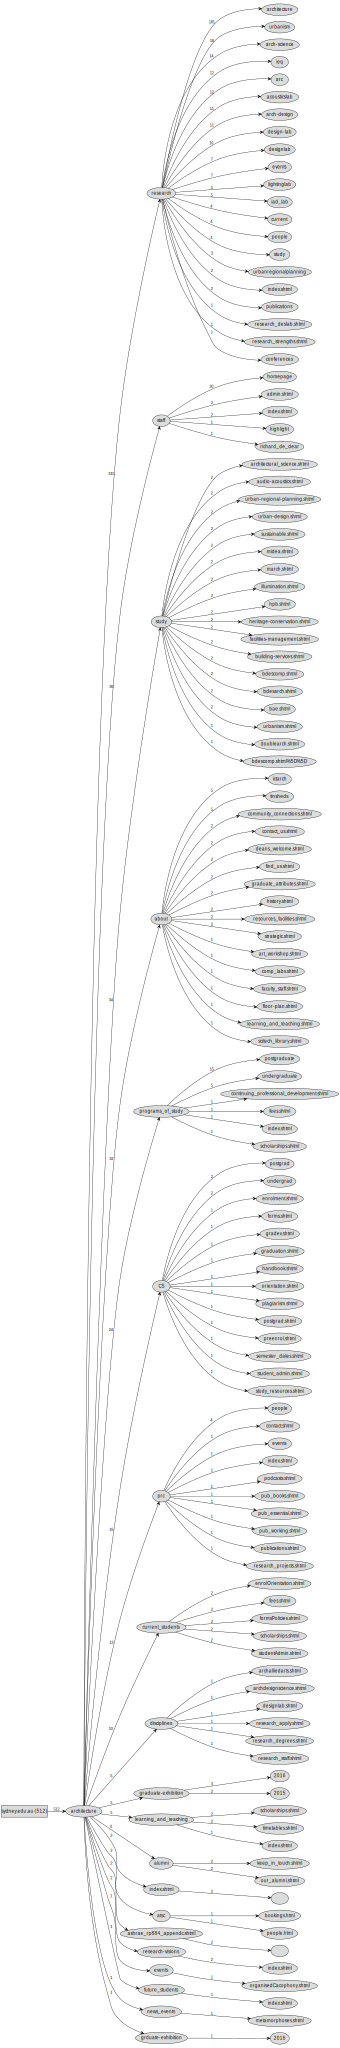

In [42]:
f = make_sitemap_graph(sitemap_layers, layers=3, size='35')
f = apply_style(f, 'light')
f.render(cleanup=True)
f

In [ ]:
# # # limit 3
# sitemap_layers = peel_layers(urls=sitemap_urls, layers=4)
# f = make_sitemap_graph(sitemap_layers, layers=5, limit=3, size='25')
# f = apply_style(f, 'light')
# f.render(cleanup=True)
# f